In [42]:
import os
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from glob import glob

from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [ ]:

def load_chest_xray_data(data_dir):
    """
    Load chest X-ray images from a directory with subfolders for each class.
    
    Parameters:
    -----------
    data_dir : str
        Path to the main directory containing subfolders with images
    
    Returns:
    --------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    label_map : dict
        Dictionary mapping label indices to label names
    image_paths : list
        List of image file paths
    """
    # Get all subdirectories (class labels)
    subfolders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    
    # Create a label mapping
    label_map = {i: label for i, label in enumerate(subfolders)}
    
    images = []
    labels = []
    image_paths = []
    
    print(f"Found {len(subfolders)} classes: {subfolders}")
    
    # Loop through each subfolder (class)
    for label_idx, subfolder in enumerate(subfolders):
        class_dir = os.path.join(data_dir, subfolder)
        print(f"Loading images from {subfolder}...")
        
        # Get all image files
        img_paths = []
        for ext in ['*.png', '*.jpg', '*.jpeg']:
            img_paths.extend(glob(os.path.join(class_dir, ext)))
        
        # Load each image
        for img_path in img_paths:
            try:
                # Read image and convert to grayscale
                img = io.imread(img_path)
                if len(img.shape) > 2:  # Check if the image has more than 2 dimensions
                    img = np.mean(img, axis=2).astype(np.uint8)  # Convert to grayscale
                
                images.append(img)
                labels.append(label_idx)
                image_paths.append(img_path)
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        print(f"Loaded {len(img_paths)} images from {subfolder}")
    
    print(f"Total loaded: {len(images)} images")
    
    return images, labels, label_map, image_paths

In [3]:
# the directory from my computer
data_dir = os.path.join(os.getcwd(), "Xray_data")

In [4]:

images, labels, label_map, image_paths = load_chest_xray_data(data_dir)


Found 3 classes: ['Normal ', 'COVID-19 cases', 'Pneumonia']
Loading images from Normal ...
Loaded 234 images from Normal 
Loading images from COVID-19 cases...
Loaded 220 images from COVID-19 cases
Loading images from Pneumonia...
Loaded 148 images from Pneumonia
Total loaded: 602 images


In [35]:
def extract_glcm_features_df(images,
                            labels,
                            image_paths, 
                            target_size=(512, 512), 
                            distances=[1, 2,3], 
                            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            g_levels=256):
    """
    Extract GLCM features from images and organize into a DataFrame with image IDs and labels.
    
    Parameters:
    -----------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    image_paths : list
        List of image file paths or IDs
    target_size : tuple
        Size to resize all images to (width, height)
    distances : list
        List of distances for GLCM calculation
    angles : list
        List of angles for GLCM calculation
    g_levels : int
        Number of gray levels to use for GLCM calculation (default is 256)

    Returns:
    --------
    df : pandas DataFrame
        DataFrame containing image_id, label, and all GLCM features
    """
    import pandas as pd
    import numpy as np
    from skimage.feature import graycomatrix, graycoprops
    from skimage.transform import resize
    import os
    
    # GLCM properties to calculate
    properties = ['contrast', 'homogeneity', 'energy', 'correlation']
    
    # Create feature labels
    feature_labels = []
    for prop in properties:
        for d in distances:
            for a in angles:
                angle_deg = int(a * 180 / np.pi)  # Convert angle to degrees
                feature_labels.append(f"{prop}_d{d}_a{angle_deg}")
    
    # Initialize feature array
    n_features = len(properties) * len(distances) * len(angles)
    features = np.zeros((len(images), n_features))
    
    # Create image IDs from paths (get filename without extension)
    if isinstance(image_paths[0], str):
        image_ids = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]
    else:
        # If not paths, use as is
        image_ids = image_paths
    
    # Extract GLCM features for each image
    for i, img in enumerate(images):
        if i % 100 == 0:
            print(f"Processing image {i}/{len(images)}")
        
        # Resize image to ensure consistency
        img_resized = resize(img, target_size, anti_aliasing=True, preserve_range=True).astype(np.uint8)
        
        # Rescale the image to have values between 0 and (levels-1)
        levels = g_levels
        # Normalization: Min-max scaling to range [0, levels-1]
        img_scaled = ((img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-10) * (levels-1)).astype(np.uint8)
        
        # Calculate GLCM
        glcm = graycomatrix(img_scaled, distances=distances, angles=angles, 
                           levels=levels, symmetric=True, normed=True)
        
        # Calculate GLCM properties
        feature_idx = 0
        for prop in properties:
            glcm_prop = graycoprops(glcm, prop)
            for d in range(len(distances)):
                for a in range(len(angles)):
                    features[i, feature_idx] = glcm_prop[d, a]
                    feature_idx += 1
    
    # Create the DataFrame
    data = {
        'image_id': image_ids,
        'label': labels
    }
    
    # Add each feature as a column
    for i, feature_name in enumerate(feature_labels):
        data[feature_name] = features[:, i]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    return glcm, df

Extracted glcm features('contrast', 'homogeneity', 'energy', and 'correlation') using distances [1,5] and angles [0, pi/2] (aka above and lateral) from the unedited x ray images.

In [36]:
glcm, glcm_df = extract_glcm_features_df(
    images, 
    labels, 
    image_paths, 
    target_size=(512, 512),
    distances=[1,5],
    angles=[0, np.pi/2]
)

Processing image 0/602
Processing image 100/602
Processing image 200/602
Processing image 300/602
Processing image 400/602
Processing image 500/602
Processing image 600/602


In [37]:
glcm_df.head()

,image_id,label,contrast_d1_a0,contrast_d1_a90,contrast_d5_a0,contrast_d5_a90,homogeneity_d1_a0,homogeneity_d1_a90,homogeneity_d5_a0,homogeneity_d5_a90,energy_d1_a0,energy_d1_a90,energy_d5_a0,energy_d5_a90,correlation_d1_a0,correlation_d1_a90,correlation_d5_a0,correlation_d5_a90
0,IM-0031-0001,0,32.150987,21.003746,306.064430,180.866941,0.282208,0.326196,0.121127,0.170384,0.020548,0.022316,0.013042,0.015071,0.995459,0.997033,0.956432,0.974229
1,IM-0025-0001,0,28.440776,23.297502,264.526446,205.709874,0.348462,0.380596,0.169743,0.203185,0.033536,0.036139,0.022824,0.025470,0.996805,0.997384,0.969978,0.976693
2,NORMAL2-IM-0272-0001,0,21.659751,16.491427,180.838214,122.916809,0.316165,0.345231,0.179568,0.216448,0.069443,0.071409,0.058250,0.068089,0.996040,0.997000,0.966088,0.977551
3,NORMAL2-IM-0102-0001,0,46.869863,24.754663,441.727568,238.282514,0.399142,0.438570,0.198082,0.258052,0.069929,0.075635,0.049731,0.069914,0.995436,0.997595,0.956285,0.976721
4,NORMAL2-IM-0229-0001,0,55.176932,32.008405,338.391962,193.645356,0.362887,0.421728,0.181895,0.252928,0.052922,0.055790,0.039841,0.049043,0.991770,0.995265,0.947567,0.971272


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    glcm_df.drop(columns=['image_id', 'label'], axis=1),
                                                    glcm_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=glcm_df['label']
                                                    )

In [39]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest on unedited data

In [40]:
# Train a Random Forest Classifier on scaled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=113, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=113)


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        70
           1       0.84      0.95      0.89        66
           2       0.82      0.71      0.76        45

    accuracy                           0.86       181
   macro avg       0.85      0.84      0.84       181
weighted avg       0.86      0.86      0.85       181


Confusion Matrix:


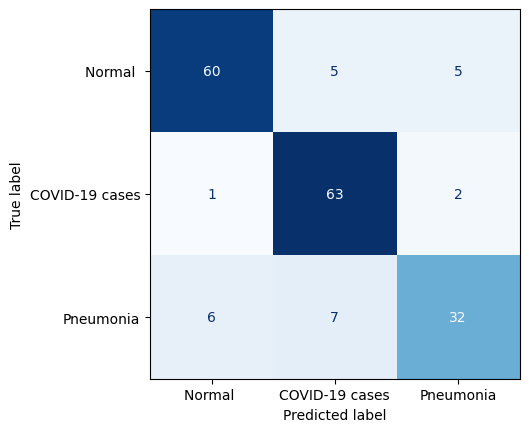

In [41]:
# Evaluate the model

y_pred = rf_model.predict(X_test_scaled)
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

# SVM on unedited data

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    SVC(kernel='rbf', random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters rbf: {grid_search.best_params_}")

Best parameters rbf: {'C': 100, 'gamma': 0.01}



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        70
           1       0.90      0.92      0.91        66
           2       0.77      0.82      0.80        45

    accuracy                           0.87       181
   macro avg       0.86      0.86      0.86       181
weighted avg       0.87      0.87      0.87       181


Confusion Matrix:


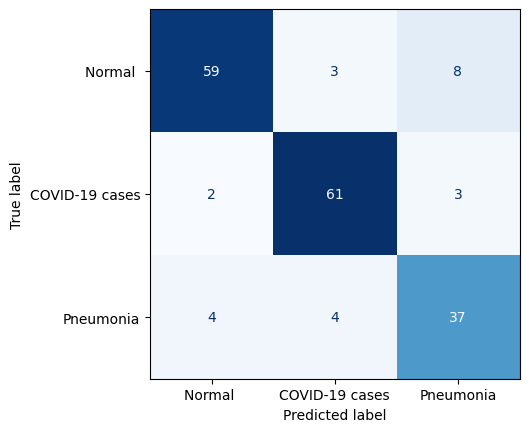

In [50]:
svm_rbf = SVC(kernel='rbf',
              C=100,
              gamma=0.01,
              class_weight='balanced',
              random_state=113
              )
svm_rbf.fit(X_train_scaled, y_train)

           
# Evaluate
y_pred = svm_rbf.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()


In [51]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    SVC(kernel='linear', random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters linear: {grid_search.best_params_}")

Best parameters linear: {'C': 10, 'gamma': 'scale'}



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        70
           1       0.88      0.89      0.89        66
           2       0.73      0.84      0.78        45

    accuracy                           0.85       181
   macro avg       0.84      0.85      0.84       181
weighted avg       0.86      0.85      0.85       181


Confusion Matrix:


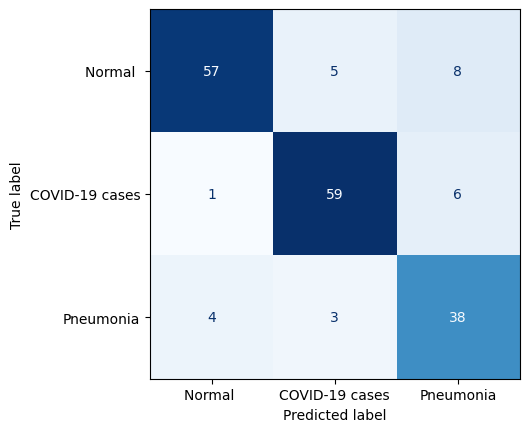

In [52]:
svm_linear = SVC(kernel='linear',
                 C=10,
                 gamma='scale',
                class_weight='balanced',
                random_state=113
                )
svm_linear.fit(X_train_scaled, y_train)

y_pred = svm_linear.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)